<a href="https://colab.research.google.com/github/josejulianhidayat/Analisis_Sentimen_Model_roBERTa_dan_K-FOLD_Cross-Validation/blob/main/Analisis_Sentimen_Model_roBERTa_K_Fold_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install transformers torch pandas

In [25]:
import pandas as pd

# Load the dataset with correct delimiter
file_path = "/content/dataset_komentar_instagram.csv"  # Pastikan nama file sesuai

try:
    # Membaca file dengan delimiter yang sesuai (;)
    dataset = pd.read_csv(file_path, encoding="latin1", delimiter=";")

    # Tampilkan informasi awal dataset
    print("Dataset berhasil dibaca!")
    print(dataset.info())
    print("Contoh data:")
    print(dataset.head())
except Exception as e:
    print(f"Terjadi error saat membaca dataset: {e}")

# Jika ingin melihat struktur file untuk memastikan format:
with open(file_path, 'r', encoding='latin1') as file:
    print("\n10 Baris Pertama dari File:")
    for i, line in enumerate(file.readlines()[:10]):
        print(f"Baris {i + 1}: {line}")


Dataset berhasil dibaca!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ï»¿comment_id   840 non-null    int64 
 1   username        840 non-null    object
 2   userid          840 non-null    int64 
 3   label_sentimen  840 non-null    object
 4   text            840 non-null    object
dtypes: int64(2), object(3)
memory usage: 32.9+ KB
None
Contoh data:
       ï»¿comment_id         username       userid label_sentimen  \
0  18205865731294506  taufiqrahman100   6259203611       Negative   
1  18044542370026087      coi_siwon45  57641547949       Negative   
2  18044484197095236      torasadytia    318015623       Negative   
3  18049045717972614        yetitaher    313460654       Negative   
4  18018004376621305    rizalrasyiiid   3746721014       Negative   

                                                text  
0              TEBANG PI

In [26]:
from transformers import pipeline

# Load the sentiment analysis pipeline
print("Memuat model RoBERTa untuk analisis sentimen...")
sentiment_pipeline = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# Pilih kolom teks untuk dianalisis
comments = dataset['text'].dropna()  # Menghapus nilai NaN jika ada

# Analisis sentimen untuk semua komentar
print("Melakukan analisis sentimen, tunggu sebentar...")
sentiment_results = sentiment_pipeline(comments.tolist())

# Tambahkan hasil sentimen ke dataset
dataset['sentiment'] = [result['label'] for result in sentiment_results]

# Tampilkan hasil contoh
print("Hasil Analisis Sentimen:")
print(dataset[['text', 'sentiment']].head())


Memuat model RoBERTa untuk analisis sentimen...
Melakukan analisis sentimen, tunggu sebentar...
Hasil Analisis Sentimen:
                                                text sentiment
0              TEBANG PILIH HANYA UNTUK OPOSISI ð  negative
1            @t0p.kom3n Aamiin ya rabbal alamin ð¤²  positive
2  bingung gak tu Kejagung, salah kebijakan tapi ...  negative
3  KASUS INI KATANYA DARI LAPORAN MASYARAKAT?? SA...  negative
4  Maaf pak, saya nggak percaya sama bapak. Nggak...  negative


In [27]:
# Simpan hasil ke file baru
output_path = "/content/analys_results.csv"
dataset.to_csv(output_path, index=False)
print(f"Hasil analisis sentimen telah disimpan ke {output_path}.")


Hasil analisis sentimen telah disimpan ke /content/analys_results.csv.


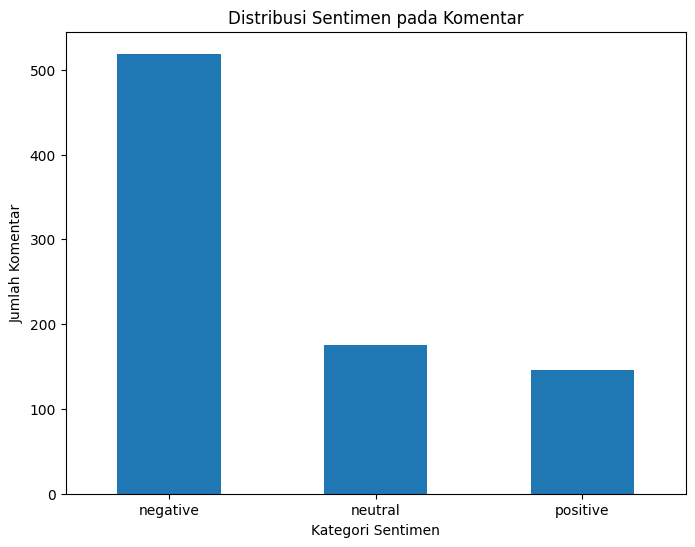

In [28]:
import matplotlib.pyplot as plt

# Visualisasi distribusi sentimen
dataset['sentiment'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title("Distribusi Sentimen pada Komentar")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xticks(rotation=0)
plt.show()


In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from transformers import pipeline
import numpy as np
import pandas as pd

# Normalize labels to lowercase for consistency
def normalize_labels(labels):
    return [label.lower() for label in labels]

# Load RoBERTa model
print("Memuat model RoBERTa untuk analisis sentimen...")
sentiment_pipeline = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

# Kolom komentar dan label sentimen
comments = dataset['text']
sentiments = dataset['label_sentimen']  # Pastikan kolom ini ada jika menggunakan ground truth

# Placeholder untuk laporan klasifikasi dan akurasi setiap fold
all_reports = []
accuracies = []

# Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(comments, sentiments)):
    print(f"\nFold {fold + 1}")

    # Split data menjadi training dan testing
    train_comments, test_comments = comments.iloc[train_index], comments.iloc[test_index]
    train_labels, test_labels = sentiments.iloc[train_index], sentiments.iloc[test_index]

    # Prediksi sentimen untuk data testing
    print("Melakukan prediksi sentimen...")
    test_predictions = sentiment_pipeline(test_comments.tolist())
    predicted_labels = normalize_labels([result['label'] for result in test_predictions])
    true_labels = normalize_labels(test_labels.tolist())

    # Evaluasi menggunakan classification_report
    report = classification_report(true_labels, predicted_labels, zero_division=1, output_dict=True)
    all_reports.append(report)

    # Hitung akurasi
    accuracy = accuracy_score(true_labels, predicted_labels)
    accuracies.append(accuracy)

    # Tampilkan laporan klasifikasi per fold
    print(f"Laporan Klasifikasi untuk Fold {fold + 1}:")
    print(classification_report(true_labels, predicted_labels, zero_division=1))
    print(f"Akurasi untuk Fold {fold + 1}: {accuracy * 100:.2f}%")

# Rata-rata metrik dari semua fold
avg_precision = np.mean([report['weighted avg']['precision'] for report in all_reports])
avg_recall = np.mean([report['weighted avg']['recall'] for report in all_reports])
avg_f1_score = np.mean([report['weighted avg']['f1-score'] for report in all_reports])
avg_accuracy = np.mean(accuracies)

print("\nRata-rata Hasil K-Fold Cross Validation:")
print(f"Rata-rata Precision: {avg_precision:.2f}")
print(f"Rata-rata Recall: {avg_recall:.2f}")
print(f"Rata-rata F1-Score: {avg_f1_score:.2f}")
print(f"Rata-rata Akurasi: {avg_accuracy * 100:.2f}%")


Memuat model RoBERTa untuk analisis sentimen...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Fold 1
Melakukan prediksi sentimen...
Laporan Klasifikasi untuk Fold 1:
              precision    recall  f1-score   support

    negative       0.94      0.61      0.74       157
     neutral       0.00      1.00      0.00         0
    positive       0.11      0.36      0.17        11

    accuracy                           0.60       168
   macro avg       0.35      0.66      0.30       168
weighted avg       0.89      0.60      0.70       168

Akurasi untuk Fold 1: 59.52%

Fold 2
Melakukan prediksi sentimen...
Laporan Klasifikasi untuk Fold 2:
              precision    recall  f1-score   support

    negative       0.93      0.63      0.76       156
     neutral       0.00      0.00      0.00         1
    positive       0.12      0.27      0.17        11

    accuracy                           0.61       168
   macro avg       0.35      0.30      0.31       168
weighted avg       0.88      0.61      0.71       168

Akurasi untuk Fold 2: 60.71%

Fold 3
Melakukan prediksi sentime

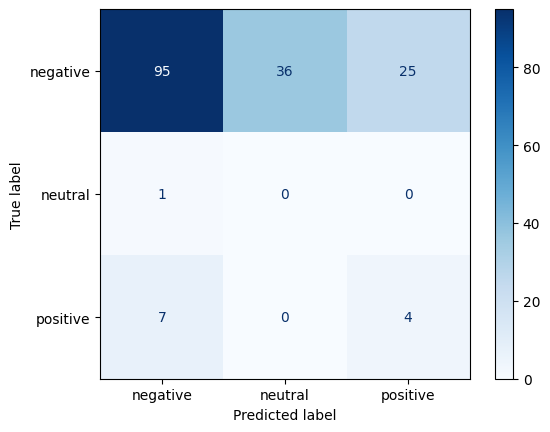

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Buat confusion matrix untuk salah satu fold
cm = confusion_matrix(true_labels, predicted_labels, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

# Tampilkan confusion matrix
disp.plot(cmap='Blues')


In [34]:
import pandas as pd

# Ganti file_path dengan path ke file dataset Anda
file_path = "/content/dataset_komentar_instagram.csv"  # Pastikan sesuai dengan file Anda
df = pd.read_csv(file_path, encoding="latin1", delimiter=";")

# Tampilkan beberapa baris untuk memastikan data sudah dimuat
print(df.head())


       ï»¿comment_id         username       userid label_sentimen  \
0  18205865731294506  taufiqrahman100   6259203611       Negative   
1  18044542370026087      coi_siwon45  57641547949       Negative   
2  18044484197095236      torasadytia    318015623       Negative   
3  18049045717972614        yetitaher    313460654       Negative   
4  18018004376621305    rizalrasyiiid   3746721014       Negative   

                                                text  
0              TEBANG PILIH HANYA UNTUK OPOSISI ð  
1            @t0p.kom3n Aamiin ya rabbal alamin ð¤²  
2  bingung gak tu Kejagung, salah kebijakan tapi ...  
3  KASUS INI KATANYA DARI LAPORAN MASYARAKAT?? SA...  
4  Maaf pak, saya nggak percaya sama bapak. Nggak...  


In [35]:
print(df.columns)


Index(['ï»¿comment_id', 'username', 'userid', 'label_sentimen', 'text'], dtype='object')


In [37]:
# Hapus label "neutral" dari dataset
df = df[df['label_sentimen'] != 'Neutral'].reset_index(drop=True)

# Konfirmasikan penghapusan
print("Distribusi label setelah penghapusan 'neutral':")
print(df['label_sentimen'].value_counts())


Distribusi label setelah penghapusan 'neutral':
label_sentimen
Negative    781
Positive     55
Name: count, dtype: int64


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd


In [41]:
# Split data menjadi training dan testing
X = df['text']  # Fitur teks
y = df['label_sentimen'].map({'Negative': 0, 'Positive': 1})  # Label numerik

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
# Konversi teks menjadi representasi numerik menggunakan TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Pilih jumlah fitur maksimal
X_train_tfidf = tfidf.fit_transform(X_train).toarray()  # Data training
X_test_tfidf = tfidf.transform(X_test).toarray()        # Data testing


In [43]:
# Terapkan SMOTE pada data training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Konversi hasil kembali ke DataFrame (opsional)
df_train_resampled = pd.DataFrame(X_train_resampled)
df_train_resampled['label'] = y_train_resampled


In [44]:
# Tampilkan distribusi label setelah SMOTE
import numpy as np

unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Distribusi label setelah SMOTE:", dict(zip(unique, counts)))


Distribusi label setelah SMOTE: {0: 624, 1: 624}


In [45]:
from datasets import Dataset

# Konversi data training dan testing ke format Hugging Face Dataset
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})


In [46]:
from transformers import AutoTokenizer

# Load tokenizer
model_checkpoint = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenisasi data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/668 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/168 [00:00<?, ? examples/s]

In [48]:
from transformers import AutoModelForSequenceClassification

# Load model untuk klasifikasi dengan 2 label (positive dan negative)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at w11wo/indonesian-roberta-base-sentiment-classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Mulai pelatihan
trainer.train()


<ipython-input-50-06117c7de994>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.284000,0.260814
2,0.191800,0.195533
3,0.167600,0.179869


TrainOutput(global_step=126, training_loss=0.21404642860094705, metrics={'train_runtime': 2167.4638, 'train_samples_per_second': 0.925, 'train_steps_per_second': 0.058, 'total_flos': 90950091839520.0, 'train_loss': 0.21404642860094705, 'epoch': 3.0})

Penjelasan Tiap Bagian
Epoch:

Merupakan iterasi ke-berapa dari dataset selama pelatihan.
Dalam kasus ini, pelatihan dilakukan selama 3 epoch.
Training Loss:

Rata-rata loss yang dihitung pada data training selama epoch tersebut.
Loss menunjukkan seberapa baik model memprediksi label pada data training.
Training Loss per Epoch:
Epoch 1: 0.284
Epoch 2: 0.192
Epoch 3: 0.168
Penurunan loss menunjukkan bahwa model belajar dengan baik.
Validation Loss:

Rata-rata loss pada data validasi (data testing yang digunakan untuk memeriksa performa model tanpa melibatkan data training).
Validation Loss per Epoch:
Epoch 1: 0.261
Epoch 2: 0.196
Epoch 3: 0.180
Penurunan Validation Loss menunjukkan bahwa model semakin baik memprediksi data yang tidak terlihat selama pelatihan.
TrainOutput (Keseluruhan):

global_step: Total jumlah langkah pelatihan (batch yang dilalui) selama pelatihan. Dalam kasus ini, 126 langkah.
training_loss: Rata-rata training loss keseluruhan (diambil rata-rata dari seluruh epoch). Dalam kasus ini, 0.214.
train_runtime: Waktu total pelatihan, yaitu 2167 detik (~36 menit).
train_samples_per_second: Kecepatan pelatihan dalam jumlah sampel yang diproses per detik (0.925 sampel/detik).
train_steps_per_second: Kecepatan pelatihan dalam langkah batch per detik (0.058 langkah/detik).
total_flos: Total operasi floating-point (FLOPS) yang digunakan selama pelatihan.
Kesimpulan Hasil
Model belajar dengan baik karena Training Loss dan Validation Loss terus menurun di setiap epoch.
Performa model cukup stabil, karena tidak ada overfitting (validation loss tidak meningkat di akhir epoch).


In [51]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.1798694133758545, 'eval_runtime': 51.3942, 'eval_samples_per_second': 3.269, 'eval_steps_per_second': 0.214, 'epoch': 3.0}


In [52]:
def predict_new_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True)
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=1)
    label_map = {0: 'Negative', 1: 'Positive'}
    return label_map[int(predictions)]

# Contoh
print(predict_new_text("Tebang Pilih !"))


Negative


In [53]:
trainer.save_model("./fine_tuned_roberta")
tokenizer.save_pretrained("./fine_tuned_roberta")


('./fine_tuned_roberta/tokenizer_config.json',
 './fine_tuned_roberta/special_tokens_map.json',
 './fine_tuned_roberta/vocab.json',
 './fine_tuned_roberta/merges.txt',
 './fine_tuned_roberta/added_tokens.json',
 './fine_tuned_roberta/tokenizer.json')

In [54]:
# Evaluasi pada data testing
results = trainer.evaluate()
print("Hasil Evaluasi:")
print(results)


Hasil Evaluasi:
{'eval_loss': 0.1798694133758545, 'eval_runtime': 45.8055, 'eval_samples_per_second': 3.668, 'eval_steps_per_second': 0.24, 'epoch': 3.0}


In [55]:
from sklearn.metrics import classification_report

# Prediksi data testing
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = test_dataset['label']

# Laporan klasifikasi
print("Laporan Klasifikasi:")
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))


Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.94      1.00      0.97       157
    Positive       1.00      0.09      0.17        11

    accuracy                           0.94       168
   macro avg       0.97      0.55      0.57       168
weighted avg       0.94      0.94      0.92       168




Interpretasi Hasil Laporan Klasifikasi
Dari hasil classification report yang Anda berikan, berikut adalah penjelasan dari metrik-metrik yang muncul:

1. Precision:
Negative: 0.94
Model sangat presisi dalam memprediksi label Negative. Artinya, 94% dari prediksi negatif model adalah benar.
Positive: 1.00
Model 100% presisi dalam memprediksi label Positive, meskipun jumlah data Positive sangat kecil.
2. Recall:
Negative: 1.00
Model berhasil menangkap semua data dengan label Negative pada data testing. Ini berarti tidak ada false negative untuk kelas ini.
Positive: 0.09
Model hanya berhasil menangkap 9% dari semua data Positive. Ini menunjukkan bahwa model sangat buruk dalam mendeteksi komentar dengan label Positive.
3. F1-Score:
Negative: 0.97
Kombinasi dari precision dan recall sangat baik untuk label Negative, menunjukkan keseimbangan antara keduanya.
Positive: 0.17
F1-score sangat rendah untuk label Positive, menunjukkan bahwa model tidak efektif dalam mengenali data positif.
4. Accuracy:
0.94 (94%)
Model memiliki akurasi tinggi secara keseluruhan, tetapi angka ini dipengaruhi oleh dominasi kelas Negative. Model lebih sering memprediksi Negative dengan benar, sehingga akurasi total tinggi.
5. Macro Avg:
Precision: 0.97, Recall: 0.55, F1-score: 0.57
Rata-rata ini menunjukkan performa model secara keseluruhan dengan mempertimbangkan kedua kelas, namun F1-score yang rendah menunjukkan bahwa model sangat tidak seimbang dalam performanya antara kelas Negative dan Positive.
6. Weighted Avg:
Precision: 0.94, Recall: 0.94, F1-score: 0.92
Ini memberikan gambaran performa model dengan mempertimbangkan ketidakseimbangan kelas. Nilai precision dan recall yang tinggi pada rata-rata berbobot menunjukkan bahwa model lebih baik dalam memprediksi kelas mayoritas (Negative).


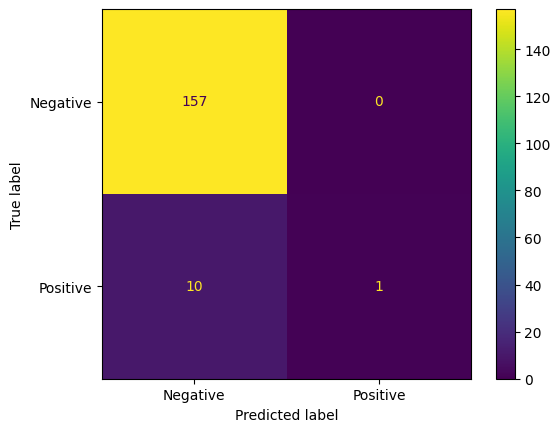

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

# Tampilkan confusion matrix
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, display_labels=['Negative', 'Positive'])
plt.show()


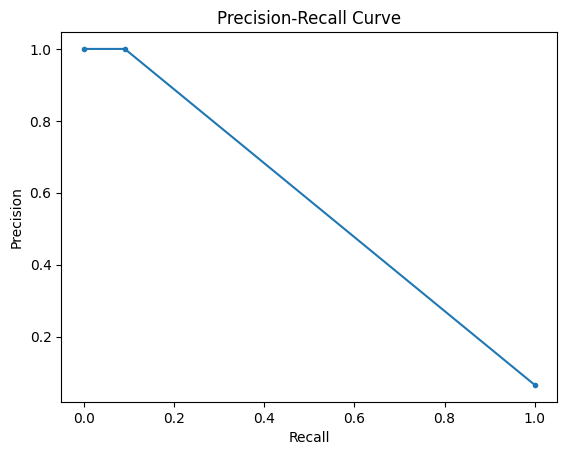

In [58]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Hitung precision, recall, dan threshold
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


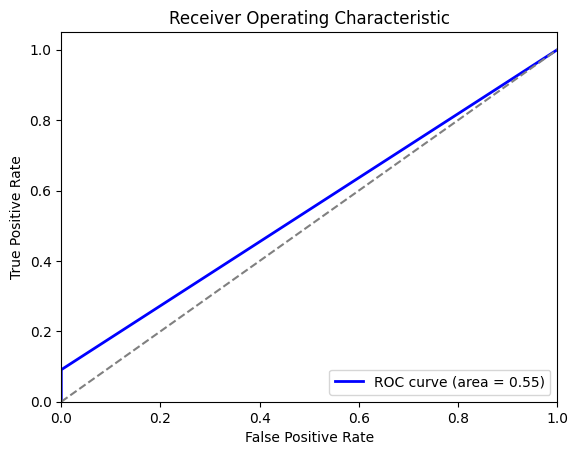

In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hitung fpr, tpr dan threshold
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Hitung AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


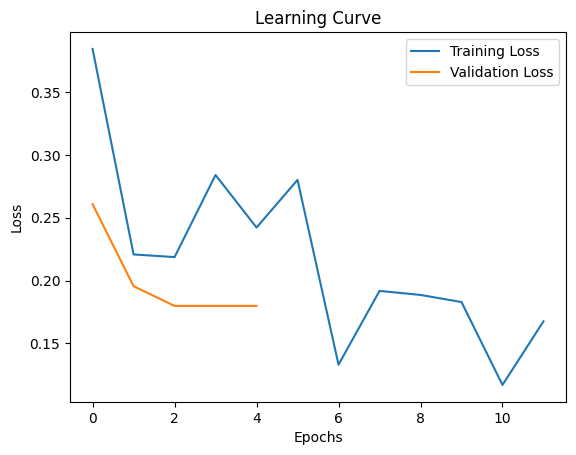

In [60]:
# Asumsi bahwa Anda telah menyimpan data loss selama pelatihan
train_losses = trainer.state.log_history
train_loss = [x['loss'] for x in train_losses if 'loss' in x]
eval_loss = [x['eval_loss'] for x in train_losses if 'eval_loss' in x]

# Plot Learning Curve
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


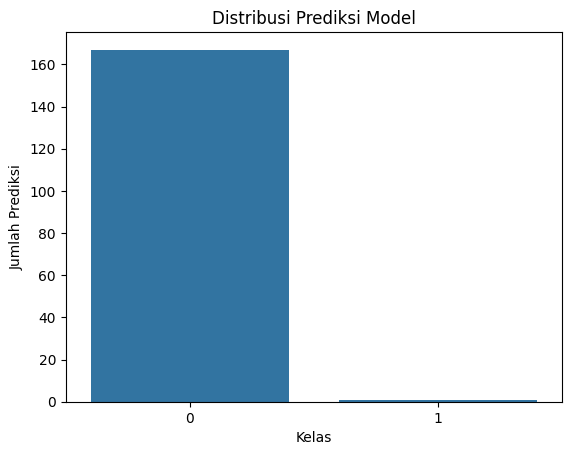

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung distribusi prediksi
prediction_distribution = pd.Series(predicted_labels).value_counts()

# Plot distribusi prediksi
sns.barplot(x=prediction_distribution.index, y=prediction_distribution.values)
plt.title('Distribusi Prediksi Model')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Prediksi')
plt.show()


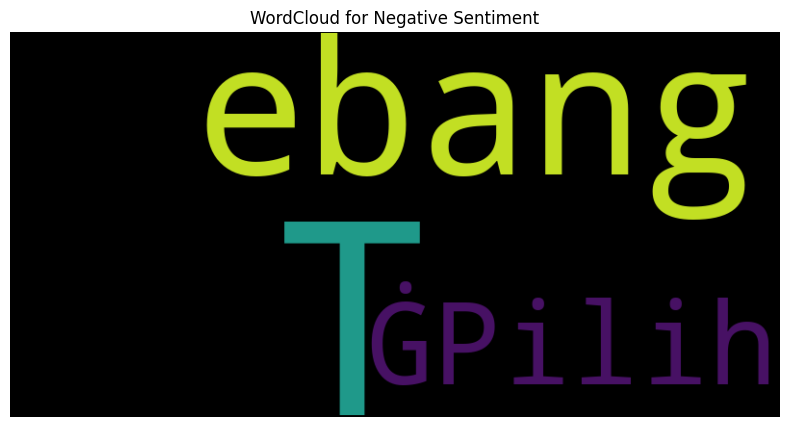

In [69]:
# Tokenisasi input untuk mendapatkan kata-kata
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Visualisasikan kata-kata dengan atribut warna berdasarkan sentimen
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Visualisasi dengan WordCloud
wordcloud = WordCloud(width=800, height=400).generate(' '.join(tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"WordCloud for {sentiment_label} Sentiment")
plt.show()
